In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import keras

from google.cloud import bigquery
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from keras.models import Sequential
from keras.layers import Dense, Normalization, Input
from keras.optimizers import Adam
from keras.metrics import RootMeanSquaredError

# プロット用
import matplotlib.pyplot as plt

# GCPプロジェクトIDを設定
# ノートブックの環境から自動で取得する場合
PROJECT = !(gcloud config get-value project)
PROJECT = PROJECT[0]
print(f"GCP Project ID: {PROJECT}")

2025-11-10 08:20:37.871007: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-10 08:20:37.940998: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/opt/conda/lib/python3.10/site-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at te

GCP Project ID: qwiklabs-asl-01-0f9e59936044


In [2]:
bq_client = bigquery.Client(project=PROJECT)

# BigQueryのデータセット名を指定
DATASET_NAME = "default"

# 3つのテーブルをマージするSQLクエリ
SQL_QUERY = f"""
WITH MonthlyData AS (
    -- 月次のスコア（t1）と月次の預金情報（t2）を結合
    SELECT
        t1.company_id,
        t1.date,
        t1.bankruptcy_score,
        -- ai_score_dummy_data のカラム
        -- カラム名にスペースが含まれるためバッククォート(``)で囲みます
        t2.`End of month account balance`,
        t2.`Monthly average account balance`,
        t2.`Monthly minimum balance`,
        t2.`Maximum monthly balance`,
        t2.`Account balance at the end of last month`,
        t2.`Last month's average account balance`,
        t2.`Last month's minimum balance`,
        t2.`Last month's maximum balance`
    FROM
        `{PROJECT}.{DATASET_NAME}.bankruptcy_data_50` AS t1
    INNER JOIN
        `{PROJECT}.{DATASET_NAME}.ai_score_dummy_data_50` AS t2
    ON
        t1.company_id = t2.company_id AND t1.date = t2.date
),
JoinedData AS (
    -- 月次データ（m）に、利用可能な直近の年次財務データ（b）を結合
    SELECT
        m.*,
        -- balance_sheet_dummy_data のカラム
        b.tangible_fixed_assets,
        b.intangible_fixed_assets,
        b.investments_and_other_assets,
        b.total_fixed_assets,
        b.cash_deposit,
        b.fiscal_adjustment_fund,
        b.total_current_assets,
        b.total_assets,
        b.total_fixed_liabilities,
        b.total_current_liabilities,
        b.total_debt,
        b.total_net_assets,
        b.total_liabilities_and_net_assets,
        -- Window関数で、各(company_id, date)のペアに対して、
        -- 決算日(b.date)が月次日(m.date)以前であるものの中で最新のランク(rn=1)を付与
        ROW_NUMBER() OVER (
            PARTITION BY m.company_id, m.date
            ORDER BY b.date DESC
        ) as rn
    FROM
        MonthlyData AS m
    LEFT JOIN
        -- 財務データは年次（例: 202112）
        `{PROJECT}.{DATASET_NAME}.balance_sheet_data_50` AS b
    ON
        m.company_id = b.company_id
        AND m.date >= b.date -- 月次日付(例: 202201)が年次決算日(例: 202112)以降
)
SELECT
    * EXCEPT(rn)
FROM
    JoinedData
WHERE
    rn = 1 -- 最新の財務データのみを選択
ORDER BY
    company_id, date
"""

print("BigQueryからデータを読み込んでいます...")
try:
    df = bq_client.query(SQL_QUERY).to_dataframe()
    print("データの読み込みが完了しました。")
    print(f"データセットの形状: {df.shape}")
    print(df.head(5))
    print(df.info())
except Exception as e:
    print(f"エラーが発生しました: {e}")
    print("テーブル名やカラム名（特にスペースや特殊文字）がBigQueryのスキーマと一致しているか確認してください。")

BigQueryからデータを読み込んでいます...
データの読み込みが完了しました。
データセットの形状: (2300, 24)
   company_id    date  bankruptcy_score  End of month account balance  \
0     1000001  202201                10                        209376   
1     1000001  202202                10                        167246   
2     1000001  202203                10                        140923   
3     1000001  202204                10                        124974   
4     1000001  202205                10                        106447   

   Monthly average account balance  Monthly minimum balance  \
0                           199890                   190651   
1                           182130                   147480   
2                           144886                   132508   
3                           128842                   105813   
4                           105531                    82397   

   Maximum monthly balance  Account balance at the end of last month  \
0                   223369                   

In [3]:
if 'df' in locals() and not df.empty:
    # 1. カラム名のクリーンアップ (スペースをアンダースコアに)
    df.columns = df.columns.str.replace(r'[^a-zA-Z0-9_]', '', regex=True).str.strip().str.replace(' ', '_')

    # # 2. 欠損値処理 (中央値で補完)
    # # まず数値型に変換できるカラムを変換（BigQueryから来ると型がObjectの場合がある）
    # for col in df.columns:
    #     if col not in ['company_id']:
    #         df[col] = pd.to_numeric(df[col], errors='coerce')
            
    # ▼▼▼【修正点】▼▼▼
    # 欠損値補完(fillna)の「前」に、カラムを 'float32' に変換します
    for col in df.columns:
        # 'date' も変換対象から除外
        if col not in ['company_id', 'date']: 
            df[col] = pd.to_numeric(df[col], errors='coerce').astype('float32')
    # ▲▲▲【修正点】▲▲▲
            
    # 中央値で補完
    df = df.fillna(df.median(numeric_only=True))

    # 3. 特徴量(X)とラベル(y)の分離
    LABEL_COLUMN = 'bankruptcy_score'
    
    # company_idとdateは学習に使わない
    ID_COLUMNS = ['company_id', 'date'] 
    
    FEATURE_NAMES = [col for col in df.columns if col not in [LABEL_COLUMN] + ID_COLUMNS]
    
    print(f"予測対象（ラベル）: {LABEL_COLUMN}")
    print(f"使用する特徴量の数: {len(FEATURE_NAMES)}")
    
    X = df[FEATURE_NAMES].astype('float32')
    y = df[LABEL_COLUMN].astype('float32')
    print(f"もとの値：{y}")
    # # yが9.0以上なら1、それ以外は0に変換
    # y = (y >= 8.0).astype(float)
    print(y)

    # 4. 訓練データと検証データに分割
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

    print(f"訓練データのサンプル数: {len(X_train)}")
    print(f"検証データのサンプル数: {len(X_valid)}")
else:
    print("データフレーム 'df' が存在しないか空です。ステップ2を先に実行してください。")

予測対象（ラベル）: bankruptcy_score
使用する特徴量の数: 21
もとの値：0       10.0
1       10.0
2       10.0
3       10.0
4       10.0
        ... 
2295     2.0
2296     2.0
2297     2.0
2298     2.0
2299     2.0
Name: bankruptcy_score, Length: 2300, dtype: float32
0       10.0
1       10.0
2       10.0
3       10.0
4       10.0
        ... 
2295     2.0
2296     2.0
2297     2.0
2298     2.0
2299     2.0
Name: bankruptcy_score, Length: 2300, dtype: float32
訓練データのサンプル数: 1840
検証データのサンプル数: 460


In [4]:
# 1. 正規化レイヤーの準備
# KerasのNormalizationレイヤーに訓練データ(X_train)を適応(adapt)させます
normalizer = Normalization(axis=-1)


# X_train (DataFrame) を .values を使って Numpy 配列に変換します
normalizer.adapt(X_train.values)

# 2. Sequentialモデルの構築
# 講義ノートブックのスタイルでモデルを定義します
model = Sequential([
    # Inputレイヤーの代わりに、適応済みのNormalizerレイヤーを最初におきます
    # input_shapeは特徴量の数 (21個) に合わせます
    normalizer,
    
    # 1層目の隠れ層 (講義の例より少し多く 32ノード)
    Dense(units=32, activation='relu', name='hidden_1'),
    
    # 2層目の隠れ層 (8ノード)
    Dense(units=8, activation='relu', name='hidden_2'),
    
    # 出力層 (回帰のため、活性化関数なし(linear)で1ノード)
    Dense(units=1, activation="sigmoid", name='output')
], name="bankruptcy_predictor")

# 3. モデルのコンパイル
# 講義ノートブックと同様に Adam オプティマイザと MSE 損失を使用します
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse', # 
    metrics=["mse"] # 
)

# 4. モデルの概要を表示
# X_trainの形状を使ってビルドしてからsummary()を呼び出す
model.build(input_shape=(None, len(FEATURE_NAMES)))
model.summary()

E0000 00:00:1762762843.039204  121758 cuda_executor.cc:1309] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1762762843.074031  121758 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "bankruptcy_predictor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 21)             │            43 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_1 (Dense)                │ (None, 32)             │           704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_2 (Dense)                │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,020 (3.99 KB)

 Trainable params: 977 (3.82 KB)

 Non-trainable params: 43 (176.00 B)

In [5]:
BATCH_SIZE = 32
EPOCHS = 20 # エポック数を10から20に増やして学習

print("モデルのトレーニングを開始します...")

history = model.fit(
    X_train,
    y_train / 10,
    validation_data=(X_valid, y_valid / 10),
    epochs=EPOCHS *5,
    batch_size=BATCH_SIZE,
    verbose=1 # 1に設定するとプログレスバーが表示されます
)

print("トレーニングが完了しました。")

モデルのトレーニングを開始します...
Epoch 1/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0884 - mse: 0.0884 - val_loss: 0.0401 - val_mse: 0.0401
Epoch 2/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0320 - mse: 0.0320 - val_loss: 0.0271 - val_mse: 0.0271
Epoch 3/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0250 - mse: 0.0250 - val_loss: 0.0238 - val_mse: 0.0238
Epoch 4/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0227 - mse: 0.0227 - val_loss: 0.0224 - val_mse: 0.0224
Epoch 5/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0215 - mse: 0.0215 - val_loss: 0.0212 - val_mse: 0.0212
Epoch 6/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0203 - mse: 0.0203 - val_loss: 0.0202 - val_mse: 0.0202
Epoch 7/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0196 - mse: 0.0196 - val_loss: 0.0189 - val_mse: 0.0189
Epoch 8/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0188 - mse: 0.0188 - val_loss: 0.0189 - val_mse: 0.0189
Epoch 9/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3m

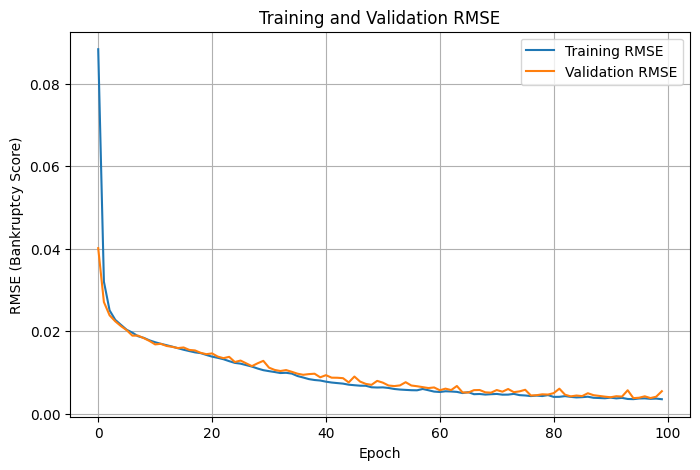

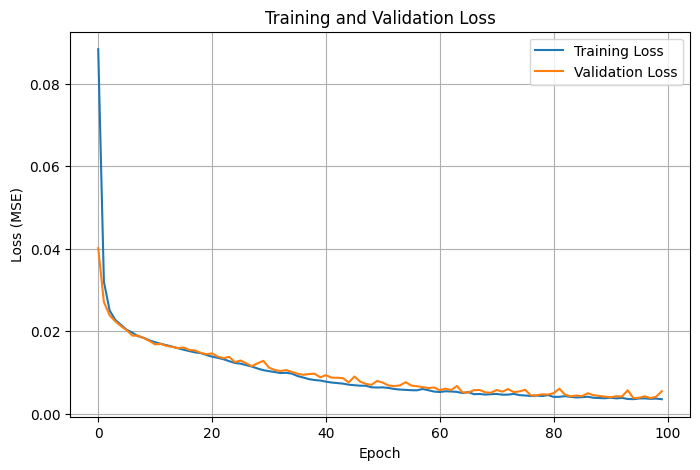

In [6]:
# 'history' オブジェクトから損失（loss）と評価指標（RMSE）を取得
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

# 1. accuracyのプロット
plt.figure(figsize=(8, 5))
plt.plot(hist['epoch'], hist['mse'], label='Training RMSE')
plt.plot(hist['epoch'], hist['val_mse'], label='Validation RMSE')
plt.title('Training and Validation RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE (Bankruptcy Score)')
plt.legend()
plt.grid(True)
plt.show()

# 2. 損失（Loss）のプロット
plt.figure(figsize=(8, 5))
plt.plot(hist['epoch'], hist['loss'], label='Training Loss')
plt.plot(hist['epoch'], hist['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

In [7]:
# 1. モデルの保存
MODEL_EXPORT_PATH = 'bankruptcy_model.keras'
model.save(MODEL_EXPORT_PATH)
print(f"モデルを {MODEL_EXPORT_PATH} に保存しました。")

# 2. 保存したモデルのロード
loaded_model = keras.models.load_model(MODEL_EXPORT_PATH)
loaded_model.summary()

# 3. 予測の実行
# 検証データから最初の5件を使って予測
sample_data = X_valid.head(5)
predictions = loaded_model.predict(sample_data)

print("\n--- 予測結果 ---")
print("入力データ（最初の5件）:")
print(sample_data)
print("\n予測スコア:")
print(predictions.flatten())
print("\n実際のスコア:")
print(y_valid.head(5))

モデルを bankruptcy_model.keras に保存しました。


Model: "bankruptcy_predictor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 21)             │            43 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_1 (Dense)                │ (None, 32)             │           704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_2 (Dense)                │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,976 (11.63 KB)

 Trainable params: 977 (3.82 KB)

 Non-trainable params: 43 (176.00 B)

 Optimizer params: 1,956 (7.64 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step

--- 予測結果 ---
入力データ（最初の5件）:
      Endofmonthaccountbalance  Monthlyaverageaccountbalance  \
741                  1606460.0                     1542338.0   
1917                28989472.0                    29952980.0   
208                    10000.0                       20000.0   
1546                11781964.0                    12415593.0   
282                    93294.0                       99578.0   

      Monthlyminimumbalance  Maximummonthlybalance  \
741               1363421.0              1790392.0   
1917             21655434.0             35313060.0   
208                  8699.0                21654.0   
1546              9375702.0             14654929.0   
282                 78530.0               115586.0   

      Accountbalanceattheendoflastmonth  Lastmonthsaverageaccountbalance  \
741                           2457586.0                        2505747.0   
1917                         28854714.0                       28159066.0

In [8]:
import pandas as pd
import numpy as np
import keras
import tensorflow as tf
from google.cloud import bigquery

# --- 1. 基本設定（ご自身の環境に合わせてください） ---

# GCPプロジェクトIDを設定
PROJECT = !(gcloud config get-value project)
PROJECT = PROJECT[0]
DATASET_NAME = "default"  # BigQueryのデータセット名

# モデルのファイルパス
MODEL_PATH = 'bankruptcy_model.keras'

# ▼▼▼【修正点 1/2】▼▼▼
# 訓練時(Step 3)のクリーニングロジック(正規表現)を適用した後の
# 正しい21個の列名リストに変更します。
FEATURE_NAMES = [
    'Endofmonthaccountbalance',
    'Monthlyaverageaccountbalance',
    'Monthlyminimumbalance',
    'Maximummonthlybalance',
    'Accountbalanceattheendoflastmonth',
    'Lastmonthsaverageaccountbalance', # 'Last_months...' から 'Lastmonths...' へ変更
    'Lastmonthsminimumbalance',      # 'Last_months...' から 'Lastmonths...' へ変更
    'Lastmonthsmaximumbalance',      # 'Last_months...' から 'Lastmonths...' へ変更
    'tangible_fixed_assets',
    'intangible_fixed_assets',
    'investments_and_other_assets',
    'total_fixed_assets',
    'cash_deposit',
    'fiscal_adjustment_fund',
    'total_current_assets',
    'total_assets',
    'total_fixed_liabilities',
    'total_current_liabilities',
    'total_debt',
    'total_net_assets',
    'total_liabilities_and_net_assets'
]
# ▲▲▲【修正点 1/2】▲▲▲


# --- 2. モデルのロードとBigQueryクライアントの初期化 ---

# モデルをロード（Keras 3はカスタムオブジェクトを自動で認識します）
try:
    print(f"モデル '{MODEL_PATH}' をロードしています...")
    loaded_model = keras.models.load_model(MODEL_PATH)
    print("モデルのロードが完了しました。")
except Exception as e:
    print(f"エラー: モデル '{MODEL_PATH}' が見つからないか、ロードできません。")
    print(e)

# BigQueryクライアントを初期化
bq_client = bigquery.Client(project=PROJECT)


# --- 3. 企業IDからスコアを予測する関数 ---

def get_latest_features(company_id_to_predict):
    """
    指定された企業IDの最新の特徴量21個をBigQueryから取得する
    """
    print(f"\n企業ID: {company_id_to_predict} の最新データをBigQueryから取得中...")
    
    job_config = bigquery.QueryJobConfig(
        query_parameters=[
            bigquery.ScalarQueryParameter("company_id_to_predict", "INT64", company_id_to_predict),
        ]
    )

    sql = f"""
    WITH MonthlyData AS (
        SELECT
            t1.company_id,
            t1.date,
            t2.`End of month account balance`,
            t2.`Monthly average account balance`,
            t2.`Monthly minimum balance`,
            t2.`Maximum monthly balance`,
            t2.`Account balance at the end of last month`,
            t2.`Last month's average account balance`,
            t2.`Last month's minimum balance`,
            t2.`Last month's maximum balance`
        FROM
            `{PROJECT}.{DATASET_NAME}.bankruptcy_data_50` AS t1
        INNER JOIN
            `{PROJECT}.{DATASET_NAME}.ai_score_dummy_data_50` AS t2
        ON
            t1.company_id = t2.company_id AND t1.date = t2.date
        WHERE t1.company_id = @company_id_to_predict
    ),
    JoinedData AS (
        SELECT
            m.*,
            b.tangible_fixed_assets,
            b.intangible_fixed_assets,
            b.investments_and_other_assets,
            b.total_fixed_assets,
            b.cash_deposit,
            b.fiscal_adjustment_fund,
            b.total_current_assets,
            b.total_assets,
            b.total_fixed_liabilities,
            b.total_current_liabilities,
            b.total_debt,
            b.total_net_assets,
            b.total_liabilities_and_net_assets,
            ROW_NUMBER() OVER (
                PARTITION BY m.company_id, m.date
                ORDER BY b.date DESC
            ) as rn
        FROM
            MonthlyData AS m
        LEFT JOIN
            `{PROJECT}.{DATASET_NAME}.balance_sheet_data_50` AS b
        ON
            m.company_id = b.company_id
            AND m.date >= b.date
    )
    SELECT
        * EXCEPT(rn, company_id, date)
    FROM
        JoinedData
    WHERE
        rn = 1
    ORDER BY
        date DESC
    LIMIT 1
    """

    try:
        df = bq_client.query(sql, job_config=job_config).to_dataframe()
        
        if df.empty:
            print(f"エラー: 企業ID {company_id_to_predict} のデータが見つかりません。")
            return None
            
        # 1. カラム名のクリーンアップ
        # ▼▼▼【修正点 2/2】▼▼▼
        # 訓練時(Step 3)と「全く同じ」クリーニング処理を実行します
        # (アポストロフィやスペースを全て削除する)
        df.columns = df.columns.str.replace(r'[^a-zA-Z0-9_]', '', regex=True).str.strip().str.replace(' ', '_')
        # ▲▲▲【修正点 2/2】▲▲▲
        
        # 2. 欠損値処理
        df = df.fillna(0)
        
        # 3. モデル入力用に21個の特徴量を正しい順序で抽出
        features_df = df[FEATURE_NAMES].astype('float32')
        
        print("データ取得完了。")
        return features_df

    except KeyError as e:
        print(f"エラー: 予測用のカラム名(FEATURE_NAMES)と、BigQueryから取得・整形したカラム名が一致しません。")
        print(f"不足しているカラム: {e}")
        print("BigQueryから取得・整形後のカラム一覧:", df.columns.tolist())
        return None
    except Exception as e:
        print(f"BigQueryからのデータ取得または処理中にエラーが発生しました: {e}")
        return None

def predict_score(company_id):
    """
    メイン関数: 企業IDを受け取り、倒産スコアを予測する
    """
    if 'loaded_model' not in globals():
        print("エラー: モデルがロードされていません。")
        return
        
    # 1. BigQueryから最新の特徴量を取得
    features_df = get_latest_features(company_id)
    print(features_df)
    
    if features_df is None:
        return
        
    # 2. 予測の実行
    features_array = features_df.values
    
    print("モデルによる予測を実行中...")
    prediction = loaded_model.predict(features_array)
    print(loaded_model.summary())
    
    # 3. 結果の整形
    score = prediction[0][0]
    print(prediction)
    print(score)
    
    return score

# --- テスト実行 ---
# 予測したい企業のIDを入力してください
TEST_COMPANY_ID = 1000029

score = predict_score(TEST_COMPANY_ID)

if score is not None:
    print("\n--- 予測結果 ---")
    print(f"企業ID: {TEST_COMPANY_ID}")
    print(f"倒産予測スコア: {score:.4f}")

モデル 'bankruptcy_model.keras' をロードしています...
モデルのロードが完了しました。

企業ID: 1000029 の最新データをBigQueryから取得中...
データ取得完了。
   Endofmonthaccountbalance  Monthlyaverageaccountbalance  \
0                   10000.0                       20000.0   

   Monthlyminimumbalance  Maximummonthlybalance  \
0                 8598.0                23560.0   

   Accountbalanceattheendoflastmonth  Lastmonthsaverageaccountbalance  \
0                            10000.0                          20000.0   

   Lastmonthsminimumbalance  Lastmonthsmaximumbalance  tangible_fixed_assets  \
0                    8104.0                   21428.0           1.406387e+10   

   intangible_fixed_assets  ...  total_fixed_assets  cash_deposit  \
0             2.406930e+09  ...        2.080193e+10  7.307348e+09   

   fiscal_adjustment_fund  total_current_assets  total_assets  \
0            3.527959e+09          1.758556e+10  3.838749e+10   

   total_fixed_liabilities  total_current_liabilities    total_debt  \
0             8.089

Model: "bankruptcy_predictor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 21)             │            43 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_1 (Dense)                │ (None, 32)             │           704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_2 (Dense)                │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,976 (11.63 KB)

 Trainable params: 977 (3.82 KB)

 Non-trainable params: 43 (176.00 B)

 Optimizer params: 1,956 (7.64 KB)

None
[[0.86315966]]
0.86315966

--- 予測結果 ---
企業ID: 1000029
倒産予測スコア: 0.8632


In [9]:
score

0.86315966

In [10]:

import pandas as pd
import numpy as np
import keras
import tensorflow as tf
from google.cloud import bigquery

# --- 1. 基本設定（変更なし） ---

PROJECT = !(gcloud config get-value project)
PROJECT = PROJECT[0]
DATASET_NAME = "default"
MODEL_PATH = 'bankruptcy_model.keras'

# 訓練時(Step 3)のクリーニングロジック(正規表現)を適用した後の
# 正しい21個の列名リスト
FEATURE_NAMES = [
    'Endofmonthaccountbalance',
    'Monthlyaverageaccountbalance',
    'Monthlyminimumbalance',
    'Maximummonthlybalance',
    'Accountbalanceattheendoflastmonth',
    'Lastmonthsaverageaccountbalance', 
    'Lastmonthsminimumbalance',      
    'Lastmonthsmaximumbalance',      
    'tangible_fixed_assets',
    'intangible_fixed_assets',
    'investments_and_other_assets',
    'total_fixed_assets',
    'cash_deposit',
    'fiscal_adjustment_fund',
    'total_current_assets',
    'total_assets',
    'total_fixed_liabilities',
    'total_current_liabilities',
    'total_debt',
    'total_net_assets',
    'total_liabilities_and_net_assets'
]

# --- 2. モデルのロードとBigQueryクライアントの初期化 (変更なし) ---

try:
    if 'loaded_model' not in globals(): # ロード済みでなければロード
        print(f"モデル '{MODEL_PATH}' をロードしています...")
        loaded_model = keras.models.load_model(MODEL_PATH)
        print("モデルのロードが完了しました。")
except Exception as e:
    print(f"エラー: モデル '{MODEL_PATH}' が見つからないか、ロードできません。")
    print(e)

if 'bq_client' not in globals():
    bq_client = bigquery.Client(project=PROJECT)


# --- 3. 企業IDからスコアを予測する関数 ---

def get_latest_features(company_id_to_predict):
    """
    指定された企業IDの最新の特徴量21個をBigQueryから取得する
    (この関数の中身は変更なし)
    """
    print(f"\n企業ID: {company_id_to_predict} の最新データをBigQueryから取得中...")
    
    job_config = bigquery.QueryJobConfig(
        query_parameters=[
            bigquery.ScalarQueryParameter("company_id_to_predict", "INT64", company_id_to_predict),
        ]
    )

    sql = f"""
    WITH MonthlyData AS (
        SELECT
            t1.company_id,
            t1.date,
            t2.`End of month account balance`,
            t2.`Monthly average account balance`,
            t2.`Monthly minimum balance`,
            t2.`Maximum monthly balance`,
            t2.`Account balance at the end of last month`,
            t2.`Last month's average account balance`,
            t2.`Last month's minimum balance`,
            t2.`Last month's maximum balance`
        FROM
            `{PROJECT}.{DATASET_NAME}.bankruptcy_data_50` AS t1
        INNER JOIN
            `{PROJECT}.{DATASET_NAME}.ai_score_dummy_data_50` AS t2
        ON
            t1.company_id = t2.company_id AND t1.date = t2.date
        WHERE t1.company_id = @company_id_to_predict
    ),
    JoinedData AS (
        SELECT
            m.*,
            b.tangible_fixed_assets,
            b.intangible_fixed_assets,
            b.investments_and_other_assets,
            b.total_fixed_assets,
            b.cash_deposit,
            b.fiscal_adjustment_fund,
            b.total_current_assets,
            b.total_assets,
            b.total_fixed_liabilities,
            b.total_current_liabilities,
            b.total_debt,
            b.total_net_assets,
            b.total_liabilities_and_net_assets,
            ROW_NUMBER() OVER (
                PARTITION BY m.company_id, m.date
                ORDER BY b.date DESC
            ) as rn
        FROM
            MonthlyData AS m
        LEFT JOIN
            `{PROJECT}.{DATASET_NAME}.balance_sheet_dummy_data` AS b
        ON
            m.company_id = b.company_id
            AND m.date >= b.date
    )
    SELECT
        * EXCEPT(rn, company_id, date)
    FROM
        JoinedData
    WHERE
        rn = 1
    ORDER BY
        date DESC
    LIMIT 1
    """

    try:
        df = bq_client.query(sql, job_config=job_config).to_dataframe()
        
        if df.empty:
            print(f"エラー: 企業ID {company_id_to_predict} のデータが見つかりません。")
            return None
            
        # 訓練時(Step 3)と「全く同じ」クリーニング処理
        df.columns = df.columns.str.replace(r'[^a-zA-Z0-9_]', '', regex=True).str.strip().str.replace(' ', '_')
        df = df.fillna(0)
        features_df = df[FEATURE_NAMES].astype('float32')
        
        print("データ取得完了。")
        return features_df

    except KeyError as e:
        print(f"エラー: 予測用のカラム名(FEATURE_NAMES)と、BigQueryから取得・整形したカラム名が一致しません。")
        print(f"不足しているカラム: {e}")
        return None
    except Exception as e:
        print(f"BigQueryからのデータ取得または処理中にエラーが発生しました: {e}")
        return None

def predict_score(company_id):
    """
    メイン関数: 企業IDを受け取り、倒産スコア(0-1)を予測する
    """
    if 'loaded_model' not in globals():
        print("エラー: モデルがロードされていません。")
        return
        
    features_df = get_latest_features(company_id)
    
    if features_df is None:
        return
        
    features_array = features_df.values
    
    print("モデルによる予測を実行中...")
    prediction = loaded_model.predict(features_array)
    
    # 予測結果（1〜10のスコア）を取得
    score_1_to_10 = prediction[0][0]
    
    # ▼▼▼【修正点】▼▼▼
    # 予測スコア(1-10)を10で割り、確率(0-1)に変換します
    score_0_to_1 = score_1_to_10 #/ 10.0
    
    # 0未満や1を超える場合は、0.0または1.0に丸めます
    final_score = np.clip(score_0_to_1, 0.0, 1.0)
    # ▲▲▲【修正点】▲▲▲
    
    return final_score

In [11]:
# --- テスト実行 ---
# 予測したい企業のIDを入力してください
TEST_COMPANY_ID = 1000050

score = predict_score(TEST_COMPANY_ID)

if score is not None:
    print("\n--- 予測結果 ---")
    print(f"企業ID: {TEST_COMPANY_ID}")
    print(f"倒産予測スコア（確率）: {score:.4f}") # 0.5272 のように表示されるはず


企業ID: 1000050 の最新データをBigQueryから取得中...
データ取得完了。
モデルによる予測を実行中...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step

--- 予測結果 ---
企業ID: 1000050
倒産予測スコア（確率）: 0.3101


In [12]:
# XAI (説明可能性) のための shap ライブラリをインストールします
!pip install shap


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [13]:
import shap
import pandas as pd
import numpy as np

# --- 1. SHAP Explainer の作成準備 ---
print("SHAP Explainer（説明器）を準備しています...")

try:
    # ステップ3で作成した訓練データ X_train が必要です
    if 'X_train' not in globals():
        raise NameError("X_train が定義されていません。ノートブックのステップ3（データの前処理）を先に実行してください。")

    # 訓練データが大きい場合があるため、代表的なサンプル100件を抽出します
    # (X_trainはPandas DataFrameなので .values で Numpy配列にします)
    background_data = shap.sample(X_train.values, 100)
    
    # Kerasモデル（loaded_model）の予測関数を SHAP に渡します
    # KernelExplainerは、モデルをブラックボックスとして扱える汎用的な説明器です
    # loaded_model.predict 関数と、背景データ（X_trainのサンプル）を渡します
    explainer = shap.KernelExplainer(loaded_model.predict, background_data)
    
    print("SHAP Explainer の準備が完了しました。")

except Exception as e:
    print(f"エラー: Explainerの作成に失敗しました。")
    print(e)
    print("ノートブックのステップ3（データの前処理）が実行されているか確認してください。")

SHAP Explainer（説明器）を準備しています...
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
SHAP Explainer の準備が完了しました。


In [14]:
# --- 4. 予測と「説明」を行う関数 ---
def predict_score_and_explain(company_id):
    """
    メイン関数: 企業IDを受け取り、倒産スコア(0-1)と「その理由」を予測する
    """
    if 'loaded_model' not in globals() or 'explainer' not in globals():
        print("エラー: モデルまたはExplainerがロードされていません。")
        return None, None
        
    # 1. BigQueryから最新の特徴量を取得
    features_df = get_latest_features(company_id)
    
    if features_df is None:
        return None, None
        
    features_array = features_df.values
    
    print("モデルによる予測を実行中...")
    prediction = loaded_model.predict(features_array)
    score_1_to_10 = prediction[0][0]
    
    # 確率(0-1)に変換
    score_0_to_1 = score_1_to_10 #/ 10.0
    final_score = np.clip(score_0_to_1, 0.0, 1.0)
    
    # --- 2. SHAPによる「理由」の計算 ---
    print("SHAPによる「理由」の計算を実行中...")
    
    # shap_values_data の形状は (1, 21, 1) (サンプル数, 特徴量数, 出力数)
    shap_values_data = explainer.shap_values(features_array)
    
    # 最初のサンプル [0] を取り出し、形状 (21, 1) を取得
    shap_values_2d = shap_values_data[0]
    
    # 3. SHAP値の解釈と「理由」の生成
    
    # ▼▼▼【修正点】▼▼▼
    # shap_values (21, 1) を .flatten() で (21,) の1次元配列に変換します
    shap_series = pd.Series(shap_values_2d.flatten(), index=FEATURE_NAMES)
    # ▲▲▲【修正点】▲▲▲
    
    # スコアを押し上げる要因（SHAP値が正）
    positive_contributors = shap_series[shap_series > 0].sort_values(ascending=False)
    
    # スコアを押し下げる要因（SHAP値が負）
    negative_contributors = shap_series[shap_series < 0].sort_values(ascending=True)

    reason = ""
    
    # 最もスコアを「押し上げた」要因（デフォルトリスクが高い理由）
    if not positive_contributors.empty:
        top_positive_feature = positive_contributors.index[0]
        reason += f"【プラス要因】: {top_positive_feature} がスコアを最も押し上げています。"
        
    # 最もスコアを「押し下げた」要因（まだ大丈夫な理由）
    if not negative_contributors.empty:
        top_negative_feature = negative_contributors.index[0]
        reason += f"\n【マイナス要因】: 一方、{top_negative_feature} がスコアを引き下げています。"

    if reason == "":
        reason = "（スコアに影響を与える明確な要因が見つかりませんでした）"

    return final_score, reason


In [15]:
# --- テスト実行 ---
# 予測したい企業のIDを入力してください
TEST_COMPANY_ID = 1000001

score, reason = predict_score_and_explain(TEST_COMPANY_ID)

if score is not None:
    print("\n--- 予測結果 ---")
    print(f"企業ID: {TEST_COMPANY_ID}")
    print(f"倒産予測スコア（確率）: {score:.4f}")
    print("\n--- スコアの主な理由 ---")
    print(reason)


企業ID: 1000001 の最新データをBigQueryから取得中...
データ取得完了。
モデルによる予測を実行中...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
SHAPによる「理由」の計算を実行中...


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
6532/6532 ━━━━━━━━━━━━━━━━━━━━ 6s 953us/step

--- 予測結果 ---
企業ID: 1000001
倒産予測スコア（確率）: 0.9031

--- スコアの主な理由 ---
【プラス要因】: Endofmonthaccountbalance がスコアを最も押し上げています。
【マイナス要因】: 一方、Accountbalanceattheendoflastmonth がスコアを引き下げています。


In [16]:
#データ不均衡の確認

# 訓練データ（y_train）の「0」と「1」の件数を確認します
if 'y_train' in globals():
    print("--- 訓練データのクラス内訳 ---")
    print(y_train.value_counts())
else:
    print("エラー: y_train が見つかりません。データ前処理のセルを先に実行してください。")

--- 訓練データのクラス内訳 ---
bankruptcy_score
2.0     728
9.0     374
8.0     374
10.0    364
Name: count, dtype: int64


In [17]:
# 3. 予測の実行
# 検証データから最初の5件を使って予測
sample_data = X_valid.head(5)
predictions = loaded_model.predict(sample_data)

print("\n--- 予測結果 ---")
print("入力データ（最初の5件）:")
print(sample_data)
print("\n予測スコア:")
print(predictions.flatten())
print("\n実際のスコア:")
print(y_valid.head(5).values)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step

--- 予測結果 ---
入力データ（最初の5件）:
      Endofmonthaccountbalance  Monthlyaverageaccountbalance  \
741                  1606460.0                     1542338.0   
1917                28989472.0                    29952980.0   
208                    10000.0                       20000.0   
1546                11781964.0                    12415593.0   
282                    93294.0                       99578.0   

      Monthlyminimumbalance  Maximummonthlybalance  \
741               1363421.0              1790392.0   
1917             21655434.0             35313060.0   
208                  8699.0                21654.0   
1546              9375702.0             14654929.0   
282                 78530.0               115586.0   

      Accountbalanceattheendoflastmonth  Lastmonthsaverageaccountbalance  \
741                           2457586.0                        2505747.0   
1917                         28854714.0                       28159066.0

In [18]:
# --- 確認用コード ---
# ID 1000001 の「最新の1行」の「元のスコア」だけを取得します

CHECK_SQL = f"""
SELECT
    t1.date,
    t1.bankruptcy_score
FROM
    `{PROJECT}.{DATASET_NAME}.bankruptcy_data_50` AS t1
WHERE
    t1.company_id = 1000001
ORDER BY
    t1.date DESC
LIMIT 1
"""

print("--- ID 1000001 の最新1行の元スコアを確認中 ---")
try:
    check_df = bq_client.query(CHECK_SQL).to_dataframe()
    if not check_df.empty:
        print(check_df)
        score = check_df['bankruptcy_score'].iloc[0]
        if score >= 8.0:
            print(f"\n結果: 元スコアは {score} (>= 8.0) です。")
            print("予測が 0.0000 になるのは「モデルの予測間違い」です。")
        else:
            print(f"\n結果: 元スコアは {score} (< 8.0) です。")
            print("予測が 0.0000 になるのは「データ（元ラベル）が 0.0 のため」です。")
            
    else:
        print("エラー: ID 1000001 のデータが見つかりません。")

except Exception as e:
    print(f"エラーが発生しました: {e}")

--- ID 1000001 の最新1行の元スコアを確認中 ---
     date  bankruptcy_score
0  202510                10

結果: 元スコアは 10 (>= 8.0) です。
予測が 0.0000 になるのは「モデルの予測間違い」です。
